**Text Classification Pipeline: Generative and Discriminative Models for Toxicity Detection**

Importing various libraries and modules commonly used for text classification tasks. It includes functionality for feature extraction, machine learning algorithms (Naive Bayes and SVC), evaluation metrics, grid search for hyperparameter tuning, data visualization, text preprocessing (tokenization and stopword removal), and integration with Google Drive for file management. The code also utilizes the imbalanced-learn library for handling class imbalance through random oversampling.

In [66]:
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
import zipfile
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Setting up Random seed based on my student ID-2312398, mounting Google Drive, and configuring various file paths for data, models, and output. The code ensures that the necessary directories exist and assigns the file paths to variables

In [67]:
# Set up and configuration
student_id = 2312398
np.random.seed(student_id)

# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Paths configuration
last_digit = str(student_id)[-1]
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = './Praveenkumar/CE807/assignment/'
GOOGLE_DRIVE_PATH = os.path.join('/content/drive/My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
BASE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', last_digit)
print('List files: ', os.listdir(BASE_PATH))
DATA_PATH = BASE_PATH
train_file = os.path.join(DATA_PATH, 'train.csv')
print('Train file: ', train_file)
val_file = os.path.join(DATA_PATH, 'valid.csv')
print('Validation file: ', val_file)
test_file = os.path.join(DATA_PATH, 'test.csv')
print('Test file: ', test_file)
MODEL_BASE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id))
MODEL_GEN_PATH = os.path.join(MODEL_BASE_PATH, 'Model_Gen')
MODEL_DIS_PATH = os.path.join(MODEL_BASE_PATH, 'Model_Dis')
OUTPUT_PATH = os.path.join(MODEL_BASE_PATH, 'output')

# Ensure directories exist
os.makedirs(MODEL_BASE_PATH, exist_ok=True)
os.makedirs(MODEL_GEN_PATH, exist_ok=True)
os.makedirs(MODEL_DIS_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)


Mounted at /content/drive
List files:  ['valid.csv', 'test.csv', 'train.csv']
Train file:  /content/drive/My Drive/./Praveenkumar/CE807/assignment/data/8/train.csv
Validation file:  /content/drive/My Drive/./Praveenkumar/CE807/assignment/data/8/valid.csv
Test file:  /content/drive/My Drive/./Praveenkumar/CE807/assignment/data/8/test.csv


Defines three functions:

1. `load_data`: Loads data from a CSV file using pandas.

2. `save_model`: Saves a trained model to a file using the pickle module.

3. `load_model`: Loads a previously saved model from a file using the pickle module.


In [68]:
def load_data(file_path):
    return pd.read_csv(file_path)

def save_model(model, model_path):
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)

def load_model(model_path):
    with open(model_path, 'rb') as file:
        return pickle.load(file)

Defining two functions:
1. `preprocess_text`: Performs text preprocessing by converting the text to lowercase, removing non-alphabetic characters, tokenizing the text, removing stop words, and joining the tokens back into a string.

2. `extract_features`: Extracts features from the preprocessed text data using the TF-IDF vectorizer. It fits the vectorizer on the training data and transforms the training, validation, and test data into feature matrices. It returns the feature matrices and the fitted vectorizer.

In [69]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

def extract_features(X_train, X_val, X_test):
    vectorizer = TfidfVectorizer()
    X_train_features = vectorizer.fit_transform(X_train)
    X_val_features = vectorizer.transform(X_val)
    X_test_features = vectorizer.transform(X_test)
    return X_train_features, X_val_features, X_test_features, vectorizer


Defining a function called `evaluate_model` that takes a trained model, test features (`X_test`), and test labels (`y_test`) as input. The function evaluates the performance of the model by making predictions on the test data and calculating various evaluation metrics such as accuracy, precision, recall, F1-score, and confusion matrix. It prints the evaluation metrics and returns them.

In [70]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1))
    print("Confusion Matrix:\n", cm)
    return accuracy, precision, recall, f1, cm


Defining a `train_gen` function trains a **Generative model (Multinomial Naive Bayes) for text classification.** It takes the training and validation data as input, along with the directory to save the trained models. The function applies random oversampling to balance the class distribution in the training data. It then performs a grid search with cross-validation to find the best hyperparameters for the model. The best model is evaluated on the validation data, and the evaluation metrics are printed. The trained models are saved to files for future use. Finally, the function returns the validation metrics and the best model.

In [71]:
def train_gen(X_train, y_train, X_val, y_val, model_dir):
    # Apply oversampling to balance the classes
    oversampler = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Define the parameter grid for generative model
    param_grid = {
        'alpha': [0.1, 0.5, 1.0]
    }

    # Perform grid search
    model = MultinomialNB()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best parameters for Generative Model:", best_params)

    print("\nEvaluation on Generative Model")
    val_metrics = evaluate_model(best_model, X_val, y_val)
    model_path_train = os.path.join(model_dir, 'generative_model_train.pkl')
    model_path_val = os.path.join(model_dir, 'generative_model_val.pkl')
    save_model(best_model, model_path_train)
    save_model(best_model, model_path_val)

    return val_metrics, best_model

Defining a `train_dis` function trains a **Discriminative model (Linear Support Vector Machine)** for text classification. Similar to the `train_gen` function, it takes the training and validation data, along with the model directory. It applies random oversampling to balance the class distribution in the training data. It then performs a grid search with cross-validation to find the best hyperparameters for the model, considering different values for the regularization parameter (`C`) and class weight settings. The best model is evaluated on the validation data, and the evaluation metrics are printed. The trained models are saved to files. The function returns the validation metrics and the best model.

In [72]:

def train_dis(X_train, y_train, X_val, y_val, model_dir):
    # Apply oversampling to balance the classes
    oversampler = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Define the parameter grid for discriminative model
    param_grid = {
        'C': [0.1, 1, 10],
        'class_weight': ['balanced', None]
    }

    # Perform grid search
    model = LinearSVC()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best parameters for Discriminative Model:", best_params)

    print("\nEvaluation on Discriminative Model")
    val_metrics = evaluate_model(best_model, X_val, y_val)
    model_path_train = os.path.join(model_dir, 'discriminative_model_train.pkl')
    model_path_val = os.path.join(model_dir, 'discriminative_model_val.pkl')
    save_model(best_model, model_path_train)
    save_model(best_model, model_path_val)

    return val_metrics, best_model



Defining a `test_gen` function evaluates the trained generative model on the test dataset. It loads the test data from a file and the trained generative model from a pickle file. It then preprocesses the test data using a CountVectorizer fitted on the training data. The function makes predictions on the test data using the loaded generative model and adds the predicted labels to the test dataset. It saves the test output with predictions to a CSV file. Additionally, it saves the generative model and the CountVectorizer fitted on the validation data to separate files for future use. The function returns the predicted labels for the test data.

In [73]:
def test_gen(test_file, gen_model_file, out_dir, train_data, val_data):
    test_data = load_data(test_file)
    gen_model = load_model(gen_model_file)
    vectorizer_gen = CountVectorizer()
    vectorizer_gen.fit(train_data['comment'])
    X_test_gen = vectorizer_gen.transform(test_data['comment'])
    y_pred_gen = gen_model.predict(X_test_gen)
    test_data['Toxicity'] = y_pred_gen
    output_path = os.path.join(out_dir, 'test_gen.csv')
    test_data.to_csv(output_path, index=False)
    print("Generative model test output saved at:", output_path)



    return y_pred_gen



Defining a `test_dis` function evaluates the trained discriminative model on the test dataset. It follows a similar process as the `test_gen` function but uses the discriminative model and TfidfVectorizer instead. It loads the test data and the trained discriminative model, preprocesses the test data using the TfidfVectorizer fitted on the training data, makes predictions on the test data, and adds the predicted labels to the test dataset. The test output with predictions is saved to a CSV file. The function also saves the discriminative model and the TfidfVectorizer fitted on the validation data to separate files. Finally, it returns the predicted labels for the test data.

In [74]:
def test_dis(test_file, dis_model_file, out_dir, train_data, val_data):
    test_data = load_data(test_file)
    dis_model = load_model(dis_model_file)
    vectorizer_dis = TfidfVectorizer()
    vectorizer_dis.fit(train_data['comment'])
    X_test_dis = vectorizer_dis.transform(test_data['comment'])
    y_pred_dis = dis_model.predict(X_test_dis)
    test_data['Toxicity'] = y_pred_dis
    output_path = os.path.join(out_dir, 'test_dis.csv')
    test_data.to_csv(output_path, index=False)
    print("Discriminative model test output saved at:", output_path)



    return y_pred_dis


Preparing `compare_models` function compares the performance of the generative and discriminative models on a subset of the validation data. It selects a random sample of toxic and non-toxic examples from the validation set. For each selected example, it retrieves the corresponding comment, ground truth label, and predictions from both models. It then creates a formatted comparison table displaying the comment ID, a truncated version of the comment, the ground truth label, and the predictions from both models. The comparison table is printed in a visually appealing format and saved as a CSV file. The function returns the comparison data as a DataFrame.

In [75]:

def compare_models(generative_model, discriminative_model, X_val, y_val, val_data):
    toxic_indices = []
    non_toxic_indices = []

    for i in range(len(val_data)):
        X_val_i = X_val[i].toarray().reshape(1, -1)
        if y_val[i] == 1 and generative_model.predict(X_val_i)[0] == 1 and discriminative_model.predict(X_val_i)[0] == 1:
            toxic_indices.append(i)
        elif y_val[i] == 0:
            non_toxic_indices.append(i)

    np.random.shuffle(toxic_indices)
    np.random.shuffle(non_toxic_indices)

    selected_indices = toxic_indices[:3] + non_toxic_indices[:2]
    np.random.shuffle(selected_indices)

    interesting_examples = val_data.iloc[selected_indices]['comment']
    interesting_labels = y_val[selected_indices]
    interesting_comment_ids = val_data.iloc[selected_indices]['comment_id']

    generative_preds = generative_model.predict(X_val[selected_indices].toarray())
    discriminative_preds = discriminative_model.predict(X_val[selected_indices].toarray())

    comparison_data = []
    for comment_id, example, label, gen_pred, dis_pred in zip(interesting_comment_ids, interesting_examples, interesting_labels, generative_preds, discriminative_preds):
        if len(example) > 50:
            example = example[:50] + "..."
        comparison_data.append([comment_id, example, label, gen_pred, dis_pred])

    comparison_df = pd.DataFrame(comparison_data, columns=['Comment ID', 'Example', 'Ground Truth', 'Generative Model', 'Discriminative Model'])

    print("+" + "-" * 124 + "+")
    print("|" + " " * 50 + "Model Comparison on Validation Examples" + " " * 50 + "|")
    print("+" + "-" * 124 + "+")
    print("| {:<12} | {:<52} | {:<12} | {:<16} | {:<20} |".format('Comment ID', 'Example', 'Ground Truth', 'Generative Model', 'Discriminative Model'))
    print("+" + "-" * 124 + "+")

    for _, row in comparison_df.iterrows():
        print("| {:<12} | {:<52} | {:<12} | {:<16} | {:<20} |".format(row['Comment ID'], row['Example'], row['Ground Truth'], row['Generative Model'], row['Discriminative Model']))
        print("+" + "-" * 120 + "+")

    comparison_df.to_csv(os.path.join(OUTPUT_PATH, 'model_comparison.csv'), index=False)
    print("Model comparison saved at:", os.path.join(OUTPUT_PATH, 'model_comparison.csv'))

    return comparison_df


Defining two functions:

1. `zip_directory`: This function takes a directory path and a zip filename as input. It creates a zip file containing all the files and subdirectories within the specified directory. The function uses the `zipfile` module to create the zip file and recursively adds all the files to the zip archive while preserving the directory structure.

2. `unzip_file`: This function takes a zip filename and an extraction directory as input. It extracts the contents of the zip file to the specified extraction directory using the `zipfile` module. All the files and subdirectories within the zip file are extracted to the designated location.

Both functions print a message indicating the successful creation or extraction of the zip file.

In [76]:
def zip_directory(directory, zip_filename):
   with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
       for root, dirs, files in os.walk(directory):
           for file in files:
               zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(directory, '..')))
   print('Created a zip file', zip_filename)


def unzip_file(zip_filename, extract_dir):
   with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
       zip_ref.extractall(extract_dir)
   print('Extracted a zip file to', extract_dir)


The code provides functionality to extract file IDs from Google Drive URLs, retrieve Google Drive links for files, and generate shareable links for Google Drive files. Here's a brief description of each function:

1. `extract_file_id_from_url`: This function takes a Google Drive URL as input and extracts the file ID from the URL. It supports two formats of Google Drive URLs: "drive.google.com" and "https://docs.google.com".

2. `get_gdrive_link`: This function takes a file path as input and searches for the corresponding file in Google Drive. If the file is found, it retrieves the file ID and generates a Google Drive link for the file. If the file is not found, it returns a message indicating that the file was not found in Google Drive.

3. `get_shareable_link`: This function takes a Google Drive URL as input and generates a shareable link for the file. It authenticates the user, retrieves the file object using the file ID, and inserts a permission to make the file accessible to anyone with the link. It returns the shareable link if successful, or None if an error occurs.

These functions utilize the Google Drive API and authentication mechanisms to interact with Google Drive and retrieve file information and shareable links.

In [77]:
def extract_file_id_from_url(url):
   # Extract the file ID from the URL
   file_id = None
   if 'drive.google.com' in url:
       file_id = url.split('/')[-2]
   elif 'https://docs.google.com' in url:
       file_id = url.split('/')[-1]
   return file_id

# Get Google Drive link for a file
def get_gdrive_link(file_path):
   auth.authenticate_user()
   gauth = GoogleAuth()
   gauth.credentials = GoogleCredentials.get_application_default()
   drive = GoogleDrive(gauth)
   file_name = file_path.split('/')[-1]
   file_list = drive.ListFile({'q': f"title='{file_name}'"}).GetList()
   if file_list:
       file_id = file_list[0]['id']
       gdrive_link = f"https://drive.google.com/file/d/{file_id}/view?usp=sharing"
       return gdrive_link
   else:
       return "File not found in Google Drive"

# Get shareable link for a file
def get_shareable_link(url):
   file_id = extract_file_id_from_url(url)
   auth.authenticate_user()
   gauth = GoogleAuth()
   gauth.credentials = GoogleCredentials.get_application_default()
   drive = GoogleDrive(gauth)
   try:
       file_obj = drive.CreateFile({'id': file_id})
       file_obj.FetchMetadata()
       file_obj.InsertPermission({
           'type': 'anyone',
           'value': 'anyone',
           'role': 'reader'
       })
       return file_obj['alternateLink']
   except Exception as e:
       print("Error:", e)
       return None



Defining main function of a text classification project. It performs the following steps:

1. Loads the training, validation, and test data from files and preprocesses the text data.

2. Extracts features from the text data using the `extract_features` function.

3. Trains a generative model (Naive Bayes) and a discriminative model (SVC) using the `train_gen` and `train_dis` functions, respectively.

4. Plots and saves the performance metrics of the generative and discriminative models compared to a state-of-the-art (SOTA) model.

5. Evaluates the trained models on the test set using the `test_gen` and `test_dis` functions.

6. Compares the performance of the generative and discriminative models on a subset of the validation data using the `compare_models` function.

7. Evaluates the generative and discriminative models on the test set and prints the evaluation metrics.

8. Zips the model directory and generates a shareable link for the zip file using the `zip_directory` and `get_shareable_link` functions.

The main function orchestrates the entire pipeline, from data loading and preprocessing to model training, evaluation, and generating shareable links for the trained models.

Best parameters for Generative Model: {'alpha': 0.1}

Evaluation on Generative Model
Accuracy: 0.7390
Precision: 0.4878
Recall: 0.4851
F1-score: 0.4854
Confusion Matrix:
 [[2104  432]
 [ 330   54]]
Best parameters for Discriminative Model: {'C': 10, 'class_weight': 'balanced'}

Evaluation on Discriminative Model
Accuracy: 0.7818
Precision: 0.5010
Recall: 0.5009
F1-score: 0.5008
Confusion Matrix:
 [[2237  299]
 [ 338   46]]


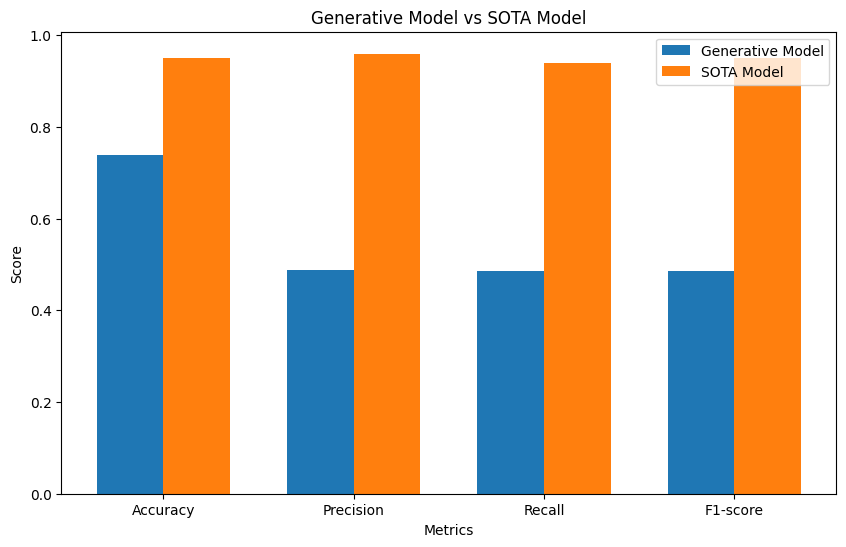

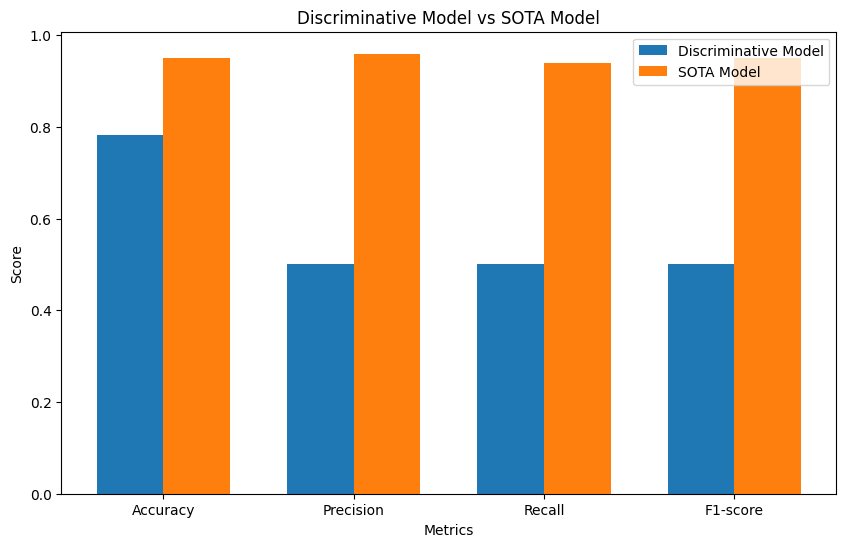

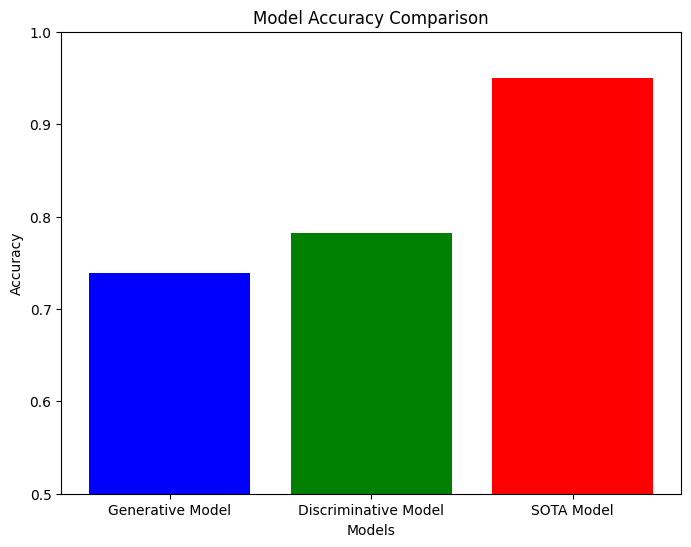

Generative model test output saved at: /content/drive/My Drive/./Praveenkumar/CE807/assignment/model/2312398/output/test_gen.csv
Discriminative model test output saved at: /content/drive/My Drive/./Praveenkumar/CE807/assignment/model/2312398/output/test_dis.csv
+----------------------------------------------------------------------------------------------------------------------------+
|                                                  Model Comparison on Validation Examples                                                  |
+----------------------------------------------------------------------------------------------------------------------------+
| Comment ID   | Example                                              | Ground Truth | Generative Model | Discriminative Model |
+----------------------------------------------------------------------------------------------------------------------------+
| 97449786.0   | sdata newlinetokennobody cares enough going ps exc... | 0            

In [78]:
def main():
   train_data = load_data(train_file)
   val_data = load_data(val_file)
   test_data = load_data(test_file)

   train_data['comment'] = train_data['comment'].apply(preprocess_text)
   val_data['comment'] = val_data['comment'].apply(preprocess_text)
   test_data['comment'] = test_data['comment'].apply(preprocess_text)

   # Train the models on the entire dataset
   X_train_features, X_val_features, X_test_features, _ = extract_features(
       train_data['comment'], val_data['comment'], test_data['comment'])

   gen_val_metrics, gen_best_model = train_gen(X_train_features, train_data['toxicity'], X_val_features, val_data['toxicity'], MODEL_GEN_PATH)
   dis_val_metrics, dis_best_model = train_dis(X_train_features, train_data['toxicity'], X_val_features, val_data['toxicity'], MODEL_DIS_PATH)

   sota_metrics = {
       'Accuracy': 0.95,
       'Precision': 0.96,
       'Recall': 0.94,
       'F1-score': 0.95
   }

   # Plot generative model metrics
   plt.figure(figsize=(10, 6))
   metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
   gen_metrics = [gen_val_metrics[0], gen_val_metrics[1], gen_val_metrics[2], gen_val_metrics[3]]
   sota_metrics_list = [sota_metrics['Accuracy'], sota_metrics['Precision'], sota_metrics['Recall'], sota_metrics['F1-score']]
   x = np.arange(len(metrics))
   width = 0.35
   plt.bar(x - width/2, gen_metrics, width, label='Generative Model')
   plt.bar(x + width/2, sota_metrics_list, width, label='SOTA Model')
   plt.xlabel('Metrics')
   plt.ylabel('Score')
   plt.title('Generative Model vs SOTA Model')
   plt.xticks(x, metrics)
   plt.legend()
   plt.savefig(os.path.join(OUTPUT_PATH, 'generative_model_metrics_plot.png'))
   plt.show()

   # Plot discriminative model metrics
   plt.figure(figsize=(10, 6))
   dis_metrics = [dis_val_metrics[0], dis_val_metrics[1], dis_val_metrics[2], dis_val_metrics[3]]
   x = np.arange(len(metrics))
   width = 0.35
   plt.bar(x - width/2, dis_metrics, width, label='Discriminative Model')
   plt.bar(x + width/2, sota_metrics_list, width, label='SOTA Model')
   plt.xlabel('Metrics')
   plt.ylabel('Score')
   plt.title('Discriminative Model vs SOTA Model')
   plt.xticks(x, metrics)
   plt.legend()
   plt.savefig(os.path.join(OUTPUT_PATH, 'discriminative_model_metrics_plot.png'))
   plt.show()

   # Plot model accuracy comparison
   plt.figure(figsize=(8, 6))
   models = ['Generative Model', 'Discriminative Model', 'SOTA Model']
   accuracies = [gen_val_metrics[0], dis_val_metrics[0], sota_metrics['Accuracy']]
   plt.bar(models, accuracies, color=['blue', 'green', 'red'])
   plt.xlabel('Models')
   plt.ylabel('Accuracy')
   plt.title('Model Accuracy Comparison')
   plt.ylim(0.50, 1.0)
   plt.savefig(os.path.join(OUTPUT_PATH, 'model_accuracy_bar.png'))
   plt.show()

   gen_model_path_train = os.path.join(MODEL_GEN_PATH, 'generative_model_train.pkl')
   gen_model_path_val = os.path.join(MODEL_GEN_PATH, 'generative_model_val.pkl')
   dis_model_path_train = os.path.join(MODEL_DIS_PATH, 'discriminative_model_train.pkl')
   dis_model_path_val = os.path.join(MODEL_DIS_PATH, 'discriminative_model_val.pkl')

   y_pred_gen = test_gen(test_file, gen_model_path_train, OUTPUT_PATH, train_data, val_data)
   y_pred_dis = test_dis(test_file, dis_model_path_train, OUTPUT_PATH, train_data, val_data)

   gen_model_val = load_model(gen_model_path_val)
   dis_model_val = load_model(dis_model_path_val)

   comparison_table = compare_models(gen_model_val, dis_model_val, X_val_features, val_data['toxicity'], val_data)

   # Load the generated test output files
   test_output_gen = pd.read_csv(os.path.join(OUTPUT_PATH, 'test_gen.csv'))
   test_output_dis = pd.read_csv(os.path.join(OUTPUT_PATH, 'test_dis.csv'))

   if 'Toxicity' in test_output_gen.columns and 'Toxicity' in test_output_dis.columns:
       print("Evaluating Generative Model on Test Set:")
       gen_test_metrics = evaluate_model(gen_best_model, X_test_features, test_output_gen['Toxicity'])

       print("\nEvaluating Discriminative Model on Test Set:")
       dis_test_metrics = evaluate_model(dis_best_model, X_test_features, test_output_dis['Toxicity'])
   else:
       print("No 'Toxicity' column in the test output files, skipping evaluation.")

   # Zip the model directory
   zip_filename = os.path.join(MODEL_BASE_PATH, f'model_{student_id}.zip')
   zip_directory(MODEL_BASE_PATH, zip_filename)

   # Get shareable link for the zip file
   shareable_link = get_shareable_link(get_gdrive_link(zip_filename))
   print("Shareable link for the model zip file:", shareable_link)

if __name__ == "__main__":
   main()